In [1]:


import numpy as np 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/monet2photo/metadata.csv
/kaggle/input/monet2photo/testB/2014-08-16 00_41_44.jpg
/kaggle/input/monet2photo/testB/2015-04-02 20_54_13.jpg
/kaggle/input/monet2photo/testB/2014-12-29 16_07_24.jpg
/kaggle/input/monet2photo/testB/2015-04-03 07_24_50.jpg
/kaggle/input/monet2photo/testB/2014-12-09 06_47_41.jpg
/kaggle/input/monet2photo/testB/2014-10-06 19_59_05.jpg
/kaggle/input/monet2photo/testB/2014-10-22 18_51_20.jpg
/kaggle/input/monet2photo/testB/2015-04-17 09_30_18.jpg
/kaggle/input/monet2photo/testB/2014-12-16 08_42_36.jpg
/kaggle/input/monet2photo/testB/2015-04-20 04_30_40.jpg
/kaggle/input/monet2photo/testB/2015-04-09 09_55_16.jpg
/kaggle/input/monet2photo/testB/2014-08-04 08_01_08.jpg
/kaggle/input/monet2photo/testB/2014-09-11 18_47_18.jpg
/kaggle/input/monet2photo/testB/2014-10-25 09_28_24.jpg
/kaggle/input/monet2photo/testB/2014-12-13 13_54_22.jpg
/kaggle/input/monet2photo/testB/2015-04-29 09_09_15.jpg
/kaggle/input/monet2photo/testB/2014-08-31 09_08_36.jpg
/kaggle/i

In [2]:
import os
import cv2
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import shutil
import itertools
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [3]:
BATCH_SIZE = 5
MONET_IMAGES_PATH = "/kaggle/input/monet2photo/trainA"
TEST_IMAGES_PATH = "/kaggle/input/monet2photo/trainB"

lr = 0.0002
beta1 = 0.5
beta2 = 0.996
n_epoches = 20
decay_epoch = 50
display_epoch = 20

In [4]:
transforms_dataset = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
class ImageDataset(Dataset):
    def __init__(self, directory_x, directory_y, test=False, transforms=None):
        self.transforms = transforms
        
        if test:
            self.monet_images_X = [directory_x + "/" + name for name in sorted(os.listdir(directory_x))[250:]]
            self.test_images_Y = [directory_y + "/" + name for name in sorted(os.listdir(directory_y))[250:301]]
        else:
            self.monet_images_X = [directory_x + "/" + name for name in sorted(os.listdir(directory_x))[:250]]
            self.test_images_Y = [directory_y + "/" + name for name in sorted(os.listdir(directory_y))[:250]]
        
    def __len__(self):
        return len(self.monet_images_X)
    
    def __getitem__(self, index):
        x_img =  Image.open(self.monet_images_X[index])
        y_img =  Image.open(self.test_images_Y[index])
        
        if self.transforms is not None:
            x_img = self.transforms(x_img)
            y_img = self.transforms(y_img)
        return x_img, y_img

In [6]:
train_loader = DataLoader(
    ImageDataset(directory_x=MONET_IMAGES_PATH, directory_y=TEST_IMAGES_PATH, test=False, transforms=transforms_dataset),
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 4
)

test_loader = DataLoader(
    ImageDataset(directory_x=MONET_IMAGES_PATH, directory_y=TEST_IMAGES_PATH, test=True, transforms=transforms_dataset),
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = 4
)

In [7]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        self.scale_factor = 16

        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ZeroPad2d((1,0,1,0)),
            nn.Conv2d(512, 1, 4, padding=1),
        )

    def forward(self, x):
        return self.model(x)

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.block(x)

class GeneratorResNet(nn.Module):
    def __init__(self, in_channels, num_residual_blocks=9):
        super(GeneratorResNet, self).__init__()

        self.initial = nn.Sequential(
            nn.ReflectionPad2d(in_channels),
            nn.Conv2d(in_channels, 64, 2 * in_channels + 1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.downsample_blocks = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.residual_blocks = nn.Sequential(*[ResidualBlock(256) for _ in range(num_residual_blocks)])

        self.upsample_blocks = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.output = nn.Sequential(
            nn.ReflectionPad2d(in_channels),
            nn.Conv2d(64, in_channels, 2 * in_channels + 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.downsample_blocks(x)
        x = self.residual_blocks(x)
        x = self.upsample_blocks(x)
        return self.output(x)

In [9]:
G_XY = GeneratorResNet(3, num_residual_blocks=9)
D_Y = Discriminator(3)

G_YX = GeneratorResNet(3, num_residual_blocks=9)
D_X = Discriminator(3)

In [10]:
# Check for CUDA availability and define the Tensor type accordingly
cuda_available = torch.cuda.is_available()
Tensor = torch.cuda.FloatTensor if cuda_available else torch.Tensor
print(f'CUDA Available: {cuda_available}')

# Transfer models to CUDA if available
models = [G_XY, D_Y, G_YX, D_X]
for model in models:
    if cuda_available:
        model.cuda()

gan_loss = nn.MSELoss().cuda()
cycle_loss = nn.L1Loss().cuda()
identity_loss = nn.L1Loss().cuda()

CUDA Available: True


In [11]:
optimizer_G = torch.optim.Adam(itertools.chain(G_XY.parameters(), G_YX.parameters()), lr=lr, betas=(beta1, beta2))
optimizer_D_X = torch.optim.Adam(D_X.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D_Y = torch.optim.Adam(D_Y.parameters(), lr=lr, betas=(beta1, beta2))

In [12]:
def learning_rate_decay(epoch, decay_start_epoch, total_epochs):
    if epoch < decay_start_epoch:
        return 1
    else:
        return 1 - (epoch - decay_start_epoch) / (total_epochs - decay_start_epoch)

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda epoch: learning_rate_decay(epoch, decay_epoch, n_epoches))
lr_scheduler_D_X = torch.optim.lr_scheduler.LambdaLR(optimizer_D_X, lr_lambda=lambda epoch: learning_rate_decay(epoch, decay_epoch, n_epoches))
lr_scheduler_D_Y = torch.optim.lr_scheduler.LambdaLR(optimizer_D_Y, lr_lambda=lambda epoch: learning_rate_decay(epoch, decay_epoch, n_epoches))

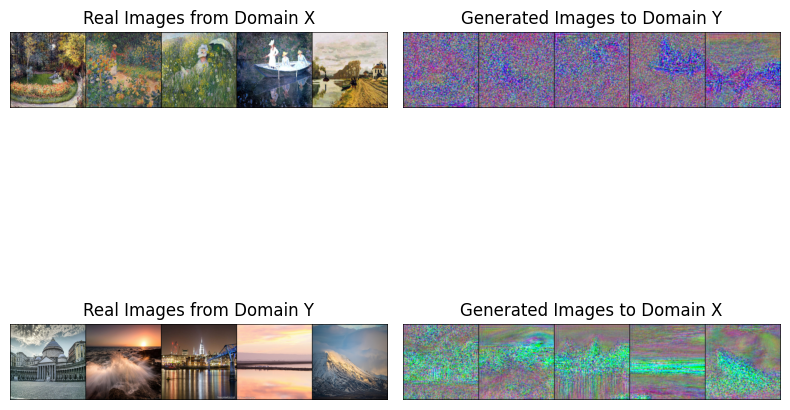

In [13]:
def sample_images(real_X, real_Y):    
    G_XY.eval()
    G_YX.eval()

    real_X = real_X.type(Tensor)
    fake_Y = G_XY(real_X).detach()

    real_Y = real_Y.type(Tensor)
    fake_X = G_YX(real_Y).detach()

    ncols = real_X.size(0)
    real_X_grid = make_grid(real_X, nrow=ncols, normalize=True)
    fake_Y_grid = make_grid(fake_Y, nrow=ncols, normalize=True)
    real_Y_grid = make_grid(real_Y, nrow=ncols, normalize=True)
    fake_X_grid = make_grid(fake_X, nrow=ncols, normalize=True)

    fig, axs = plt.subplots(2, 2, figsize=(8, 8))  

    axs[0, 0].imshow(real_X_grid.permute(1, 2, 0).cpu())
    axs[0, 0].set_title("Real Images from Domain X")
    axs[0, 0].axis('off')

    axs[0, 1].imshow(fake_Y_grid.permute(1, 2, 0).cpu())
    axs[0, 1].set_title("Generated Images to Domain Y")
    axs[0, 1].axis('off')

    axs[1, 0].imshow(real_Y_grid.permute(1, 2, 0).cpu())
    axs[1, 0].set_title("Real Images from Domain Y")
    axs[1, 0].axis('off')

    axs[1, 1].imshow(fake_X_grid.permute(1, 2, 0).cpu())
    axs[1, 1].set_title("Generated Images to Domain X")
    axs[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

real_X, real_Y = next(iter(test_loader))
sample_images(real_X, real_Y)

In [14]:
import os

# Set the directory for saving models
save_dir = '/kaggle/working/'

# Check if the directory exists, if not, create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

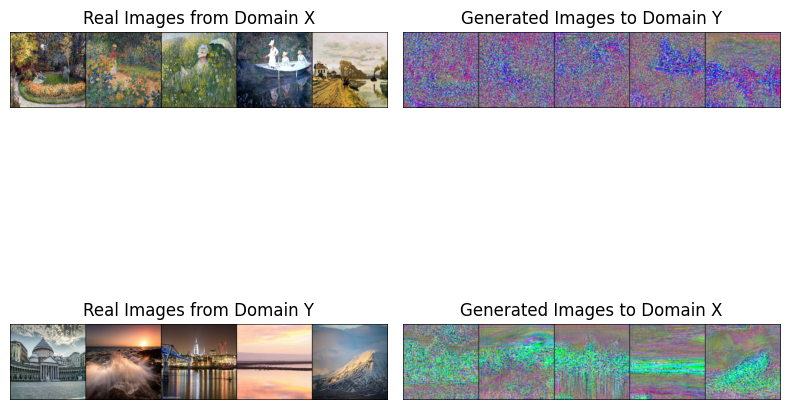

In [15]:
real_X, real_Y = next(iter(test_loader))
sample_images(real_X, real_Y)

Epoch 1/20: 100%|██████████| 50/50 [02:23<00:00,  2.87s/it]


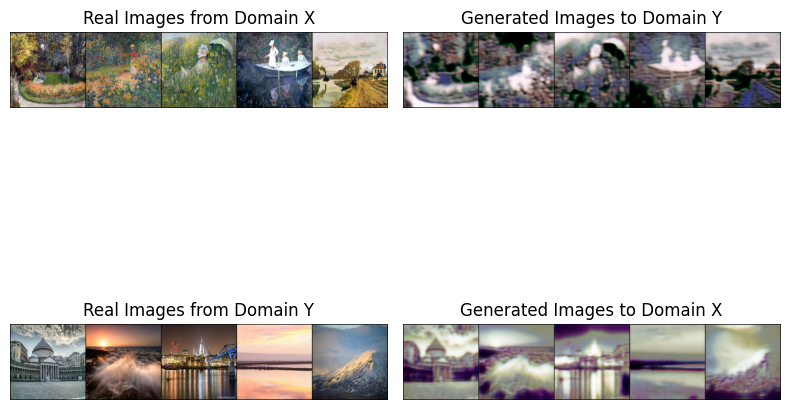

[Epoch 1 / 20]
[Generator loss: 3.902226686477661 | identity: 0.31941795349121094 GAN: 0.395599365234375 cycle: 0.3187209367752075]
[Discriminator loss: 0.20692721009254456 | D_X: 0.22782038152217865 D_Y: 0.18603405356407166]


Epoch 2/20: 100%|██████████| 50/50 [02:28<00:00,  2.97s/it]


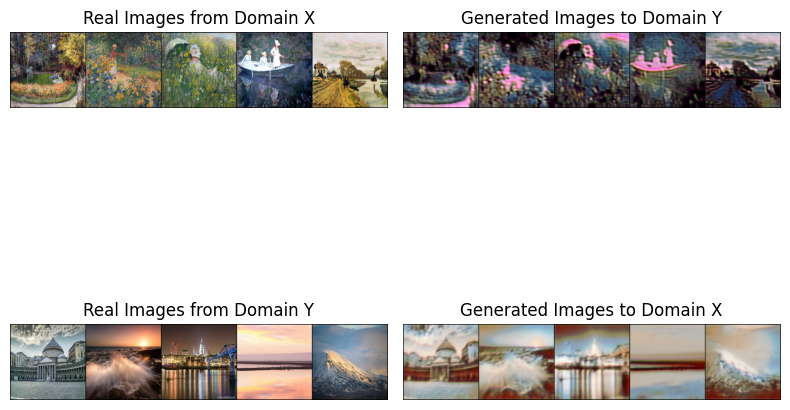

[Epoch 2 / 20]
[Generator loss: 3.727482318878174 | identity: 0.30523329973220825 GAN: 0.4495983421802521 cycle: 0.29726505279541016]
[Discriminator loss: 0.21369367837905884 | D_X: 0.2584298253059387 D_Y: 0.16895754635334015]


Epoch 3/20: 100%|██████████| 50/50 [02:28<00:00,  2.98s/it]


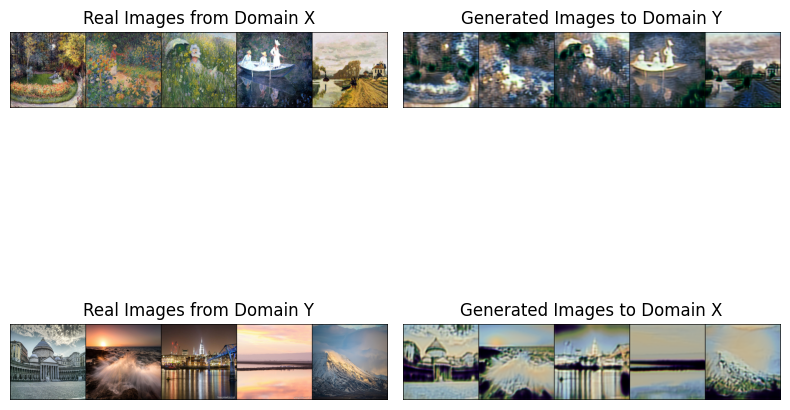

[Epoch 3 / 20]
[Generator loss: 3.5339982509613037 | identity: 0.3125775158405304 GAN: 0.39709967374801636 cycle: 0.28243210911750793]
[Discriminator loss: 0.1909894049167633 | D_X: 0.20281365513801575 D_Y: 0.17916515469551086]


Epoch 4/20: 100%|██████████| 50/50 [02:28<00:00,  2.98s/it]


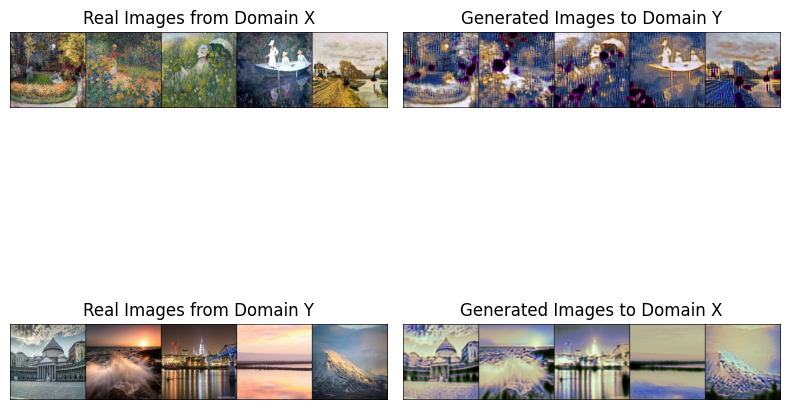

[Epoch 4 / 20]
[Generator loss: 4.194930076599121 | identity: 0.3494105935096741 GAN: 0.5182461738586426 cycle: 0.332727313041687]
[Discriminator loss: 0.14287114143371582 | D_X: 0.20301641523838043 D_Y: 0.08272585272789001]


Epoch 5/20: 100%|██████████| 50/50 [02:29<00:00,  2.98s/it]


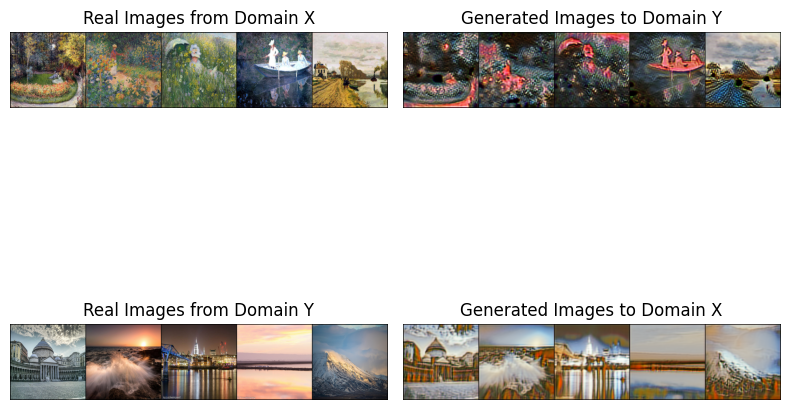

[Epoch 5 / 20]
[Generator loss: 3.0526351928710938 | identity: 0.2862265408039093 GAN: 0.32401514053344727 cycle: 0.24423936009407043]
[Discriminator loss: 0.18234358727931976 | D_X: 0.17579469084739685 D_Y: 0.18889248371124268]


Epoch 6/20: 100%|██████████| 50/50 [02:29<00:00,  2.98s/it]


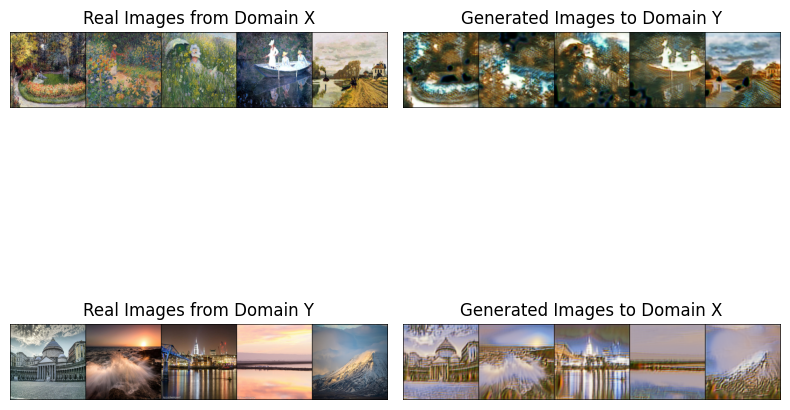

[Epoch 6 / 20]
[Generator loss: 3.8451626300811768 | identity: 0.3119363486766815 GAN: 0.5687990188598633 cycle: 0.2964427173137665]
[Discriminator loss: 0.16129721701145172 | D_X: 0.11603759229183197 D_Y: 0.20655684173107147]


Epoch 7/20: 100%|██████████| 50/50 [02:28<00:00,  2.98s/it]


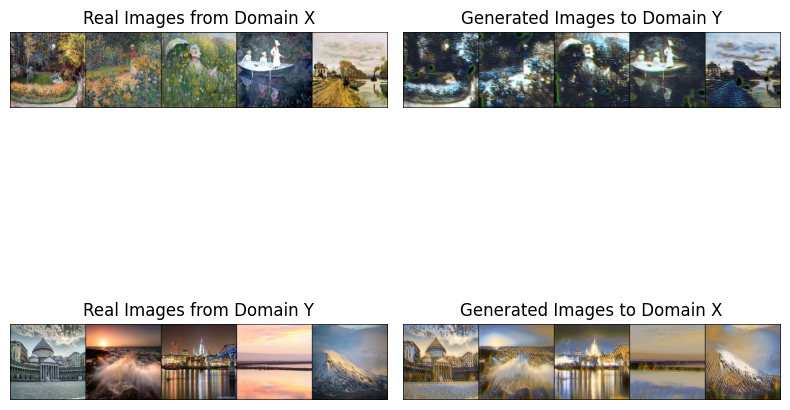

[Epoch 7 / 20]
[Generator loss: 3.985729694366455 | identity: 0.3376595675945282 GAN: 0.41287174820899963 cycle: 0.32351982593536377]
[Discriminator loss: 0.13381794095039368 | D_X: 0.12298497557640076 D_Y: 0.1446509212255478]


Epoch 8/20: 100%|██████████| 50/50 [02:29<00:00,  2.99s/it]


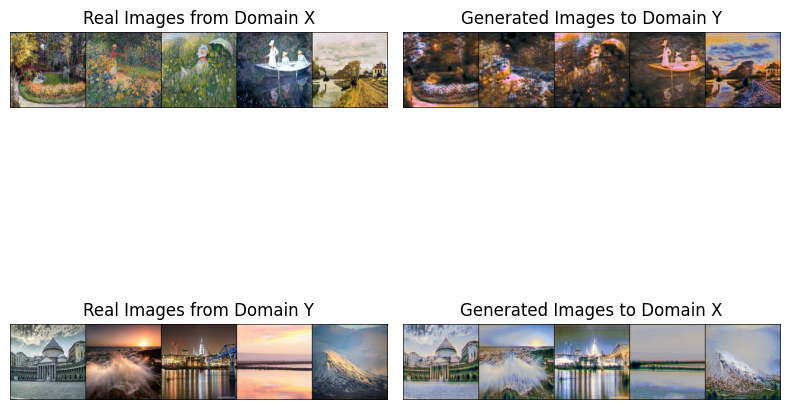

[Epoch 8 / 20]
[Generator loss: 2.904242753982544 | identity: 0.2770065665245056 GAN: 0.32249221205711365 cycle: 0.23047439754009247]
[Discriminator loss: 0.2202467918395996 | D_X: 0.23599952459335327 D_Y: 0.20449405908584595]


Epoch 9/20: 100%|██████████| 50/50 [02:28<00:00,  2.98s/it]


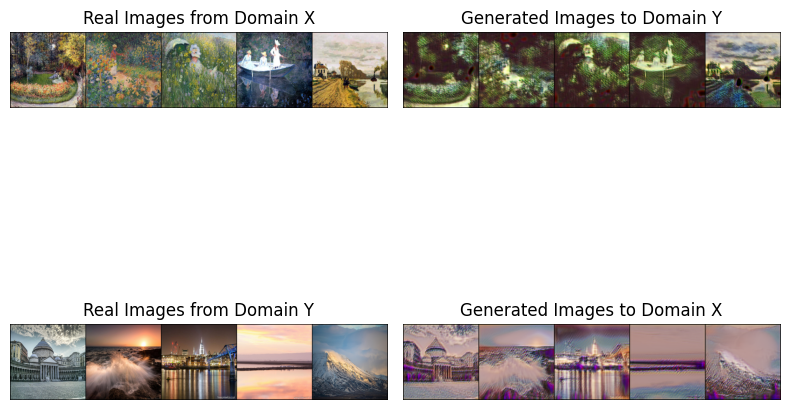

[Epoch 9 / 20]
[Generator loss: 3.0927767753601074 | identity: 0.3033652901649475 GAN: 0.5152785778045654 cycle: 0.22741329669952393]
[Discriminator loss: 0.14222969114780426 | D_X: 0.15662071108818054 D_Y: 0.12783867120742798]


Epoch 10/20: 100%|██████████| 50/50 [02:29<00:00,  2.98s/it]


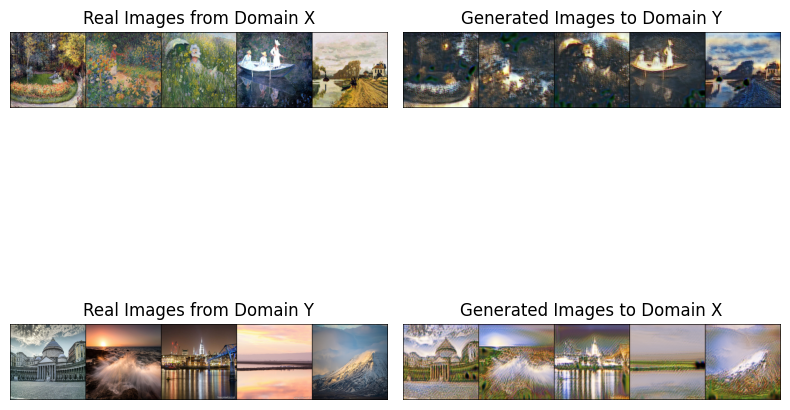

[Epoch 10 / 20]
[Generator loss: 3.8569860458374023 | identity: 0.307869553565979 GAN: 0.5764069557189941 cycle: 0.2972709536552429]
[Discriminator loss: 0.305350661277771 | D_X: 0.3445013761520386 D_Y: 0.2661999464035034]


Epoch 11/20: 100%|██████████| 50/50 [02:29<00:00,  2.98s/it]


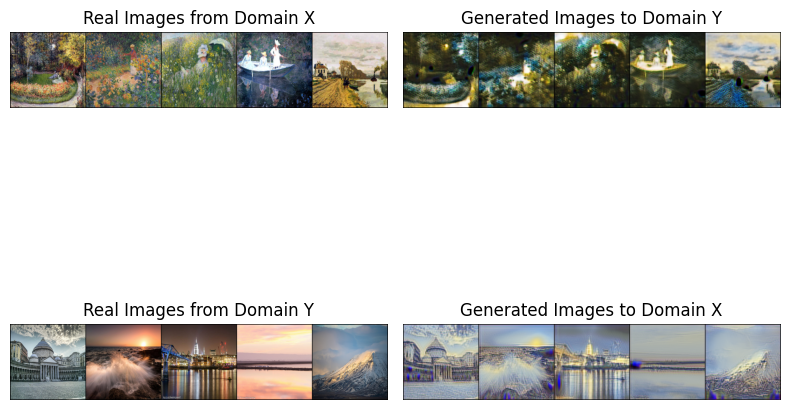

[Epoch 11 / 20]
[Generator loss: 3.450989007949829 | identity: 0.33497172594070435 GAN: 0.3851141333580017 cycle: 0.27309030294418335]
[Discriminator loss: 0.2027355134487152 | D_X: 0.2553342580795288 D_Y: 0.1501367688179016]


Epoch 12/20: 100%|██████████| 50/50 [02:29<00:00,  2.98s/it]


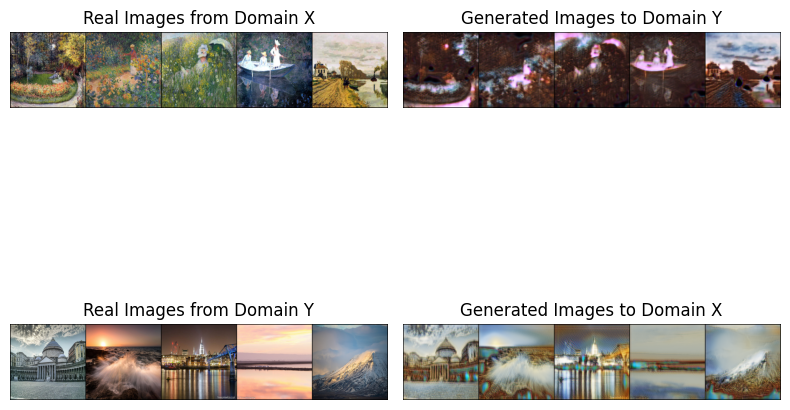

[Epoch 12 / 20]
[Generator loss: 3.645270824432373 | identity: 0.3083227574825287 GAN: 0.32013002038002014 cycle: 0.3016818165779114]
[Discriminator loss: 0.21855168044567108 | D_X: 0.2843405604362488 D_Y: 0.15276280045509338]


Epoch 13/20: 100%|██████████| 50/50 [02:29<00:00,  2.98s/it]


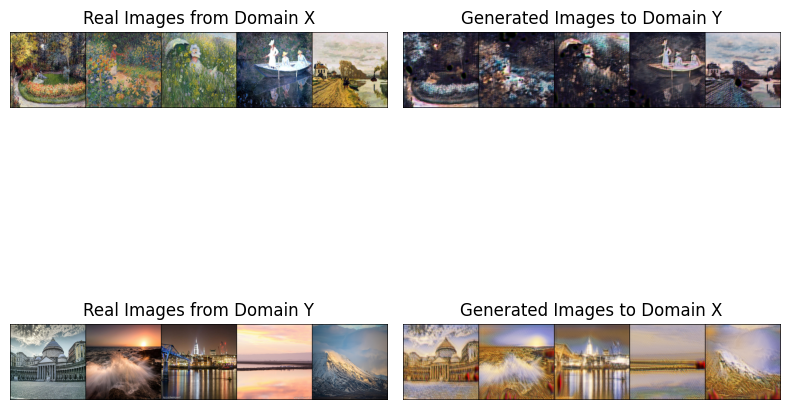

[Epoch 13 / 20]
[Generator loss: 3.329702377319336 | identity: 0.30986011028289795 GAN: 0.22066271305084229 cycle: 0.27991795539855957]
[Discriminator loss: 0.23938807845115662 | D_X: 0.25232410430908203 D_Y: 0.22645203769207]


Epoch 14/20: 100%|██████████| 50/50 [02:29<00:00,  2.99s/it]


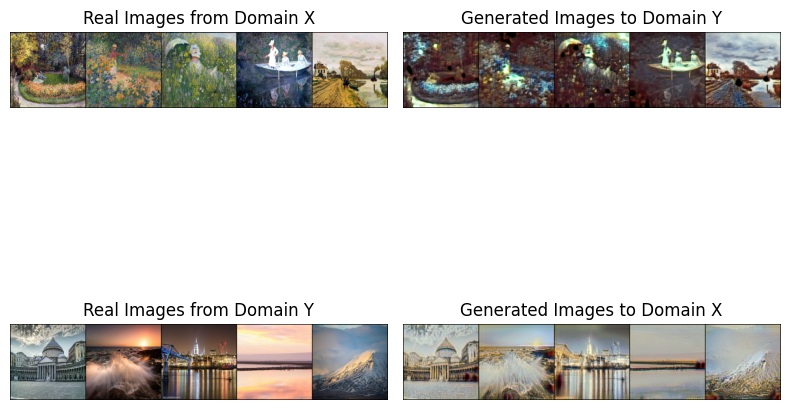

[Epoch 14 / 20]
[Generator loss: 3.228074550628662 | identity: 0.27693742513656616 GAN: 0.5897468328475952 cycle: 0.23613902926445007]
[Discriminator loss: 0.16031678020954132 | D_X: 0.1646130084991455 D_Y: 0.15602055191993713]


Epoch 15/20: 100%|██████████| 50/50 [02:29<00:00,  2.99s/it]


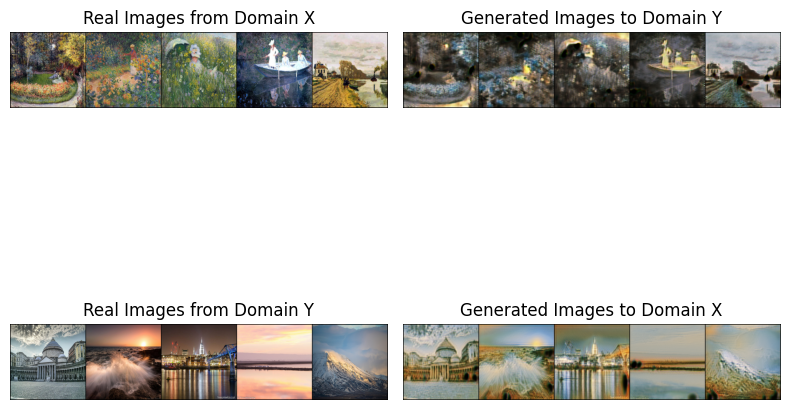

[Epoch 15 / 20]
[Generator loss: 3.213390350341797 | identity: 0.2764154076576233 GAN: 0.35297340154647827 cycle: 0.2584001421928406]
[Discriminator loss: 0.2330699861049652 | D_X: 0.24567991495132446 D_Y: 0.22046004235744476]


Epoch 16/20: 100%|██████████| 50/50 [02:29<00:00,  2.99s/it]


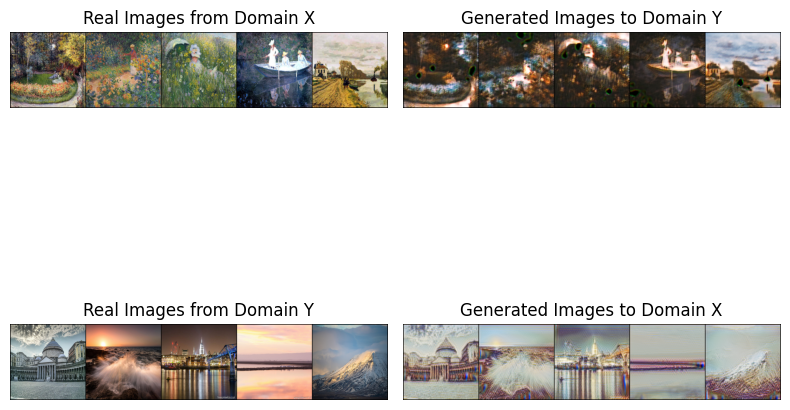

[Epoch 16 / 20]
[Generator loss: 2.7637791633605957 | identity: 0.29005712270736694 GAN: 0.20905525982379913 cycle: 0.22646667063236237]
[Discriminator loss: 0.23885756731033325 | D_X: 0.2294342815876007 D_Y: 0.2482808530330658]


Epoch 17/20: 100%|██████████| 50/50 [02:29<00:00,  2.98s/it]


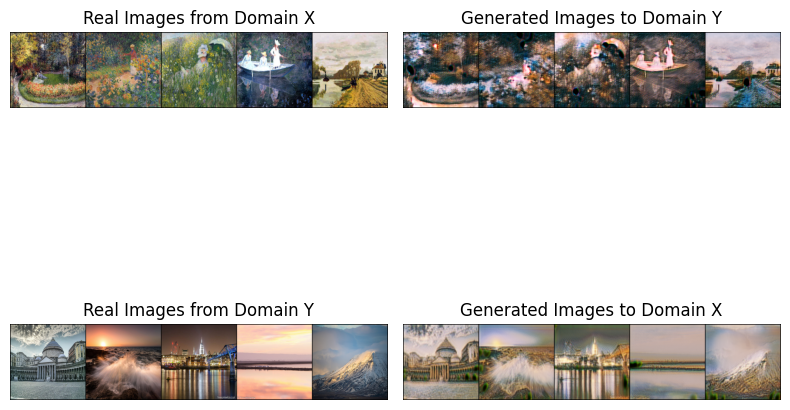

[Epoch 17 / 20]
[Generator loss: 3.6112418174743652 | identity: 0.30810731649398804 GAN: 0.4549497961997986 cycle: 0.28481847047805786]
[Discriminator loss: 0.16227832436561584 | D_X: 0.15385566651821136 D_Y: 0.17070099711418152]


Epoch 18/20: 100%|██████████| 50/50 [02:29<00:00,  2.99s/it]


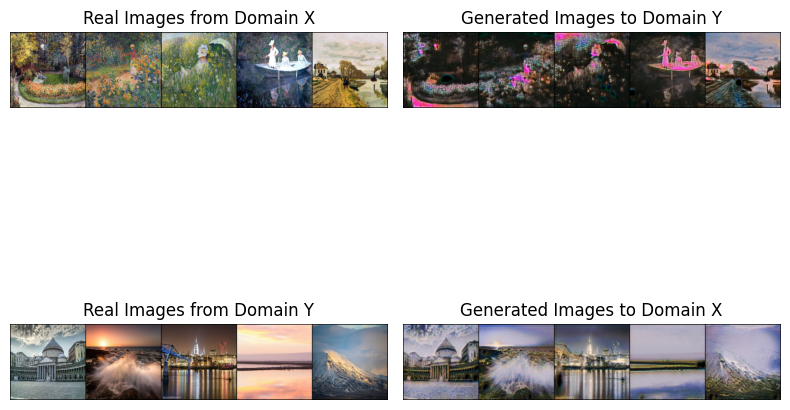

[Epoch 18 / 20]
[Generator loss: 2.967644691467285 | identity: 0.23433899879455566 GAN: 0.34459757804870605 cycle: 0.23887081444263458]
[Discriminator loss: 0.20921210944652557 | D_X: 0.3041812777519226 D_Y: 0.11424294114112854]


Epoch 19/20: 100%|██████████| 50/50 [02:28<00:00,  2.98s/it]


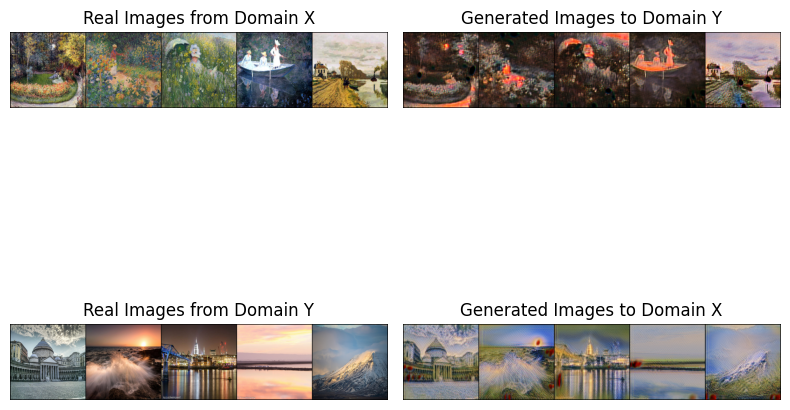

[Epoch 19 / 20]
[Generator loss: 2.8582215309143066 | identity: 0.2600984573364258 GAN: 0.5788130760192871 cycle: 0.20193099975585938]
[Discriminator loss: 0.15614837408065796 | D_X: 0.1658184975385666 D_Y: 0.14647825062274933]


Epoch 20/20: 100%|██████████| 50/50 [02:29<00:00,  2.99s/it]


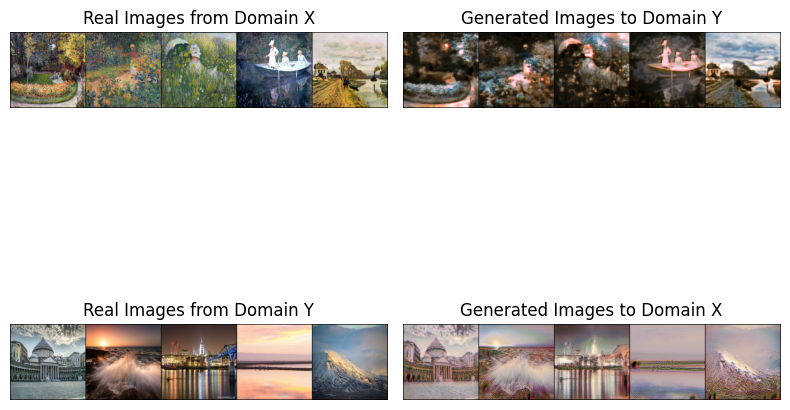

[Epoch 20 / 20]
[Generator loss: 2.651285171508789 | identity: 0.2334001064300537 GAN: 0.36568790674209595 cycle: 0.20521971583366394]
[Discriminator loss: 0.19967199862003326 | D_X: 0.16886809468269348 D_Y: 0.23047590255737305]


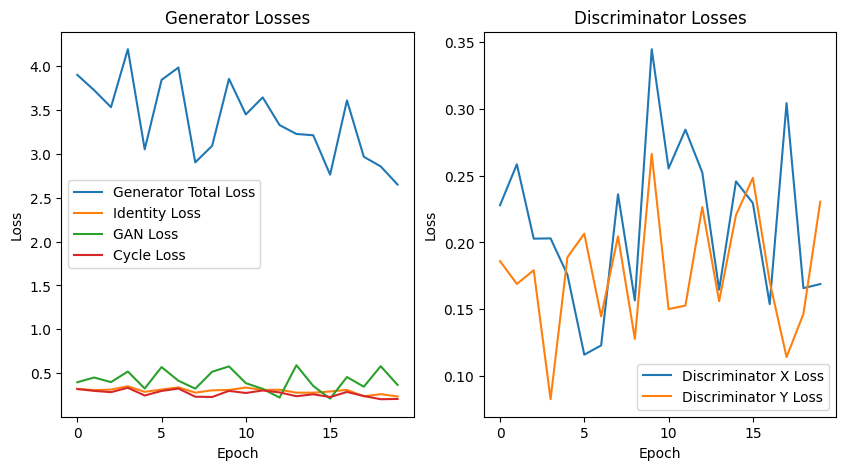

In [16]:
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bar

# Lists to store losses
losses_G = []
losses_identity = []
losses_GAN = []
losses_cycle = []

losses_D = []
losses_D_X = []
losses_D_Y = []

for epoch in range(n_epoches):
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{n_epoches}")
    for i, (real_X, real_Y) in progress_bar:
        
        real_X, real_Y = real_X.type(Tensor), real_Y.type(Tensor)
        out_shape = [real_X.size(0), 1, real_X.size(2) // D_X.scale_factor, real_X.size(3) // D_X.scale_factor]
        
        valid = torch.ones(out_shape).type(Tensor)
        fake = torch.zeros(out_shape).type(Tensor)
        
        # training generators
        G_XY.train()
        G_YX.train()
        
        optimizer_G.zero_grad()
        
        fake_Y = G_XY(real_X)
        fake_X = G_YX(real_Y)
        
        # identity loss
        loss_id_X = identity_loss(G_YX(real_X), real_X)
        loss_id_Y = identity_loss(G_XY(real_Y), real_Y)
        loss_identity = (loss_id_X + loss_id_Y) / 2
        
        # gan loss
        loss_GAN_XY = gan_loss(D_Y(fake_Y), valid) 
        loss_GAN_YX = gan_loss(D_X(fake_X), valid)
        loss_GAN = (loss_GAN_XY + loss_GAN_YX) / 2
        
        # cycle loss
        recov_X = G_YX(fake_Y)
        recov_Y = G_XY(fake_X)
        
        loss_cycle_X = cycle_loss(recov_X, real_X)
        loss_cycle_Y = cycle_loss(recov_Y, real_Y)
        loss_cycle = (loss_cycle_X + loss_cycle_Y) / 2
        
        # total gan loss
        loss_G = loss_identity + loss_GAN + 10.0 * loss_cycle
        
        loss_G.backward()
        optimizer_G.step()
        
        # training discriminator X
        optimizer_D_X.zero_grad()
        
        loss_real = gan_loss(D_X(real_X), valid)
        loss_fake = gan_loss(D_X(fake_X.detach()), fake)
        loss_D_X = (loss_real + loss_fake) / 2
        
        loss_D_X.backward()
        optimizer_D_X.step()
        
        # training discriminator Y
        optimizer_D_Y.zero_grad()
        
        loss_real = gan_loss(D_Y(real_Y), valid)
        loss_fake = gan_loss(D_Y(fake_Y.detach()), fake)
        loss_D_Y = (loss_real + loss_fake) / 2
        
        loss_D_Y.backward()
        optimizer_D_Y.step()
        
    lr_scheduler_G.step()
    lr_scheduler_D_X.step()
    lr_scheduler_D_Y.step()
    
    # Store losses
    losses_G.append(loss_G.item())
    losses_identity.append(loss_identity.item())
    losses_GAN.append(loss_GAN.item())
    losses_cycle.append(loss_cycle.item())
    
    losses_D_X.append(loss_D_X.item())
    losses_D_Y.append(loss_D_Y.item())
    
    test_real_X, test_real_Y = next(iter(test_loader))
    sample_images(test_real_X, test_real_Y)
    
    loss_D = (loss_D_X + loss_D_Y) / 2
    print(f'[Epoch {epoch + 1} / {n_epoches}]')
    print(f'[Generator loss: {loss_G.item()} | identity: {loss_identity.item()} GAN: {loss_GAN.item()} cycle: {loss_cycle.item()}]')
    print(f'[Discriminator loss: {loss_D.item()} | D_X: {loss_D_X.item()} D_Y: {loss_D_Y.item()}]')
    
    # Define the paths for saving generator and discriminator models
    G_XY_path = os.path.join(save_dir, f'G_XY_epoch_{epoch + 1}.pt')
    G_YX_path = os.path.join(save_dir, f'G_YX_epoch_{epoch + 1}.pt')
    D_X_path = os.path.join(save_dir, f'D_X_epoch_{epoch + 1}.pt')
    D_Y_path = os.path.join(save_dir, f'D_Y_epoch_{epoch + 1}.pt')
    
    # Save the models
    torch.save(G_XY.state_dict(), G_XY_path)
    torch.save(G_YX.state_dict(), G_YX_path)
    torch.save(D_X.state_dict(), D_X_path)
    torch.save(D_Y.state_dict(), D_Y_path)

# Plot losses
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(losses_G, label='Generator Total Loss')
plt.plot(losses_identity, label='Identity Loss')
plt.plot(losses_GAN, label='GAN Loss')
plt.plot(losses_cycle, label='Cycle Loss')
plt.title('Generator Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(losses_D_X, label='Discriminator X Loss')
plt.plot(losses_D_Y, label='Discriminator Y Loss')
plt.title('Discriminator Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
